In [1]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

from src.experiment import train_federated
from src.pipelines import dataset_drift, dataset_outliers, dataset_hidden_outliers
from src.utils import parse_filename, normalize

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "100_100_100_0.2_0.05_0.03_0.5_0.5_d.npy"
out_name = "100_100_100_0.2_0.05_0.03_0.5_0.5_o.npy"
data = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params = parse_filename(data_name)
params

{'num_devices': 100,
 'n': 100,
 'dims': 100,
 'subspace_frac': 0.2,
 'frac_outlying_devices': 0.05,
 'frac_outlying_data': 0.03,
 'gamma': 0.5,
 'delta': 0.5}

In [3]:
num_devices = params["num_devices"]
dims = params["dims"]
num_data = params["n"]
subspace_frac = ["subspace_frac"]
frac_outlying_devices = params["frac_outlying_devices"]
frac_outlying_data = params["frac_outlying_data"]

T_start = 1
T = 9
n = int(num_data/(T_start+T))

In [4]:
# CREATE N FEDERATED MODELS
models = []
compression_factor = 0.8
encoding_dim = int(dims*compression_factor)
for i in range(num_devices):
    input_data = Input(shape=(dims,))
    encoded = Dense(encoding_dim,
                    activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2())(input_data)
    decoded = Dense(dims, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2())(encoded)
    autoencoder = Model(input_data, decoded)
    models.append(autoencoder)
models = np.array(models)

In [5]:
# SAME WEIGHT INITIALIZATION FOR ALL MODELS
initial_weights = models[0].get_weights()
[model.set_weights(initial_weights) for model in models]
for model in models:
    model.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
# TRAIN FEDERATED
frac_available = 0.1
client_ids = range(num_devices)
global_epochs = 20
local_epochs = 1
batch_size = 1

# pre train
print("PRE TRAINING")
for t in range(1, T_start+1):
    data_start = data[:, n*(t-1):t*n]
    models = train_federated(models, data_start, local_epochs, batch_size, frac_available)

print("START MONITORING")
predictions = np.array([])
for t in range(1, T+1):
    print("t = {}".format(t))
    new_data = data[:, n*(t+T_start-1):n*(t+T_start)]
    models = train_federated(models, new_data, local_epochs, batch_size, frac_available)
    new_predictions = np.array([model.predict(new_data[i]) for i, model in enumerate(models)])
    predictions = new_predictions if t == 1 else np.concatenate((predictions, new_predictions), axis=1)
    

PRE TRAINING
Train on 10 devices
Train on 10 samples
10/10 [==============================] - 1s 76ms/sample - loss: 2.4229
Train on 10 samples
10/10 [==============================] - 0s 42ms/sample - loss: 2.4321
Train on 10 samples
10/10 [==============================] - 0s 41ms/sample - loss: 2.4393
Train on 10 samples
10/10 [==============================] - 0s 42ms/sample - loss: 2.3569
Train on 10 samples
10/10 [==============================] - 0s 40ms/sample - loss: 2.5326
Train on 10 samples
10/10 [==============================] - 1s 60ms/sample - loss: 2.4147
Train on 10 samples
10/10 [==============================] - 0s 40ms/sample - loss: 2.4202
Train on 10 samples
10/10 [==============================] - 0s 40ms/sample - loss: 2.4153
Train on 10 samples
10/10 [==============================] - 0s 40ms/sample - loss: 2.4099
Train on 10 samples
10/10 [==============================] - 0s 40ms/sample - loss: 2.4874
START MONITORING
t = 1
Train on 10 devices
Train on 10 sa

(100, 90)
(100, 90)


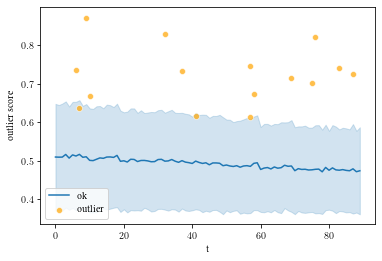

In [8]:
diff = data[:, T_start*n:] - predictions
dist = np.linalg.norm(diff, axis=-1)
dist = dist/np.max(dist)
labels = is_outlier[:, T_start*n:].any(axis=-1)

print(dist.shape)
print(labels.shape)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band")
sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("t")
plt.ylabel("outlier score")
plt.legend()
plt.show()

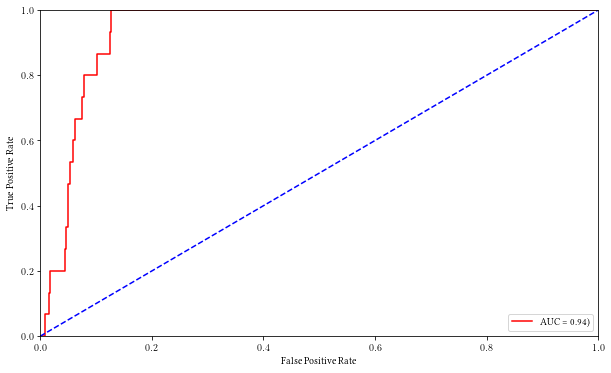

In [9]:
fpr, tpr, thresholds = roc_curve(labels.flatten(), dist.flatten())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='red', label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")
plt.show()